# Saltzman-Lorenz model

This program belongs to the project done in the course __LINMA2361 - Système Dynamiques non linéaires : Analysis of the Saltzman-Lorenz equations.__

In this program we first will __produce__ the famous __Lorenz-map__ in order to safely ruling out stable limit cycles in the strange attractor regime of the Saltzman-Lorenz equations. __Then__ we will __compute__ the __largest Lyapunov exponent__ of the system. The __code comes from the notes LPHYS2114 - Nonlinear Dynamics from M.Crucifix__. Lastly a __personnal simulation__ of the __Lorenz model__ for __very turbulent flow__ is achieved. 

---
## The Lorenz-map

In [1]:
using Pkg
using ODE

Definition of the Saltzman-Lorenz model

In [2]:
function lorenz_model(σ,ρ,β)
    function lorenz(t,u)
        dxdt = σ*(u[2]-u[1])
        dydt = u[1]*(ρ-u[3]) - u[2]
        dzdt = u[1]*u[2] - β*u[3]
        [dxdt;dydt;dzdt]
    end
    return(lorenz)
end

lorenz_model (generic function with 1 method)

We know carry out the numerical integration, with the ode45 Runge-Kutta integration on a time grid

In [3]:
dt = 0.001
tf = 100.0
t = collect(0:dt:tf)
u0=[0.;0.1;0.1]
σ=10
β=8/3.
ρ=28.
(t, u) = ode45(lorenz_model(σ,ρ,β), u0, t);

The following commands simply map the three components of the u matrix on vectors x, y and z.

In [4]:
x = map(v -> v[1], u)
y = map(v -> v[2], u)
z = map(v -> v[3], u);

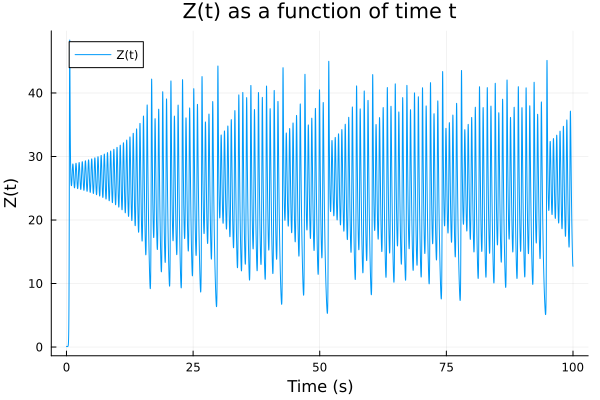

In [5]:
using Plots
plot(t,z, title = "Z(t) as a function of time t", xlabel = "Time (s)", ylabel = "Z(t)", label  = "Z(t)")

We now use the Peaks contributed package to extract the local maxima of the z−series

In [6]:
using Peaks

In [7]:
Zmax=findmaxima(z);

and we plot this series with respect to that same series shifted by one element. Mathematically, we plot
Zi+1 agains Zi , where Z is the series of maxima

In [8]:
Zmax1 = Zmax[2][1:(length(Zmax[2]))-1];
Zmax2 = Zmax[2][2:(length(Zmax[2]))];

In [9]:
plot(Zmax1,Zmax2, seriestype = :scatter, label = "Z_{n+1}", xlabel ="Z_n", ylabel = "Z_{n+1}");

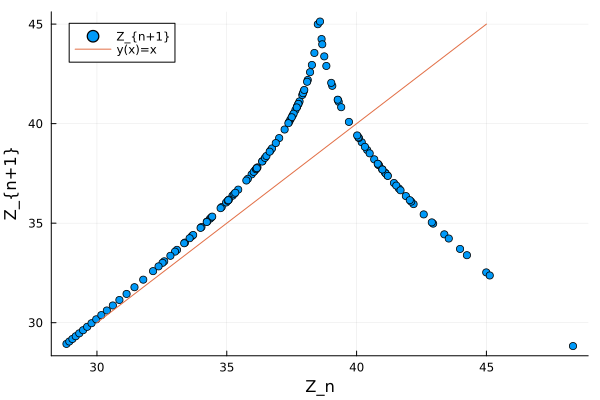

In [10]:
plot!([30,45],[30,45], label = "y(x)=x")

As we see it, the series of Z behaves as a tent-map which, as we will see in the next section, is indeed
chaotic.

---
## Numerical computation of the largest Lyapunov exponent

We now __compute the largest Lyapunov exponent__ according to the algorithm of Benettin 1980. Again, define
the Lorenz model

In [11]:
using ODE
using Pkg
using LinearAlgebra
using Plots

The Lorenz model can be simply defined. We provide a
function of the parameters, which returns the Lorenz model.

In [12]:
function lorenz_model(σ,ρ,β)
    function lorenz(t,u)
        dxdt = σ*(u[2]-u[1])
        dydt = u[1]*(ρ-u[3]) - u[2]
        dzdt = u[1]*u[2] - β*u[3]
        [dxdt;dydt;dzdt]
    end
    return(lorenz)
end

lorenz_model (generic function with 1 method)

We produce a time series

In [13]:
dt = 0.01
tf = 2000.0
t = collect(0:dt:tf)
u0=[0.1;0.1;0.1]
σ=10
β=8/3.
ρ=28.
(t, u) = ode45(lorenz_model(σ,ρ,β), u0, t);

We now consider the dynamics of a first-order perturbation δu evaluated in u:

In [14]:
function lorenz_linear_tangent(σ,ρ,β)
    function linear_tangent(δu,u)
        dδxdt = -σ*δu[1] + σ*δu[2]
        dδydt = (ρ-u[3])*δu[1] - δu[2] - u[1]*δu[3]
        dδzdt = u[2]*δu[1] + u[1]*δu[2] - β*δu[3]
        return([dδxdt; dδydt ; dδzdt ])
    end
    return(linear_tangent)
end

lorenz_linear_tangent (generic function with 1 method)

We consider an arbitrary initial perturbation δu of norm ||δu|| = 1, and code it as a column vector

In [15]:
deltau=[0;1.;0.]

3-element Vector{Float64}:
 0.0
 1.0
 0.0

In [16]:
function iterate_lyapunov(linear_tangent, deltau, u, spinup, iren)

    lambda=1. ; time = 0;
    lambdas=[];
    times=[];
    δu = deltau;
    i=0; j=0;
    for u_ in u;
        # the second order scheme appears here crucial to have good-enough results
        predictor = δu + linear_tangent(δu,u_)*dt
        δu += 0.5*(linear_tangent(δu,u_) + linear_tangent(predictor,u_)) *dt
        i+=1;
        j+=1;
        if (i==iren);
            ndu = norm(δu)
            δu=δu/ndu
            i=0;
            if(j > spinup);
                time += dt*iren
                lambda+=log(ndu)
                append!(lambdas,lambda)
                append!(times, time)
            end;
        end;
    end
    return(times, lambdas)
end

iterate_lyapunov (generic function with 1 method)

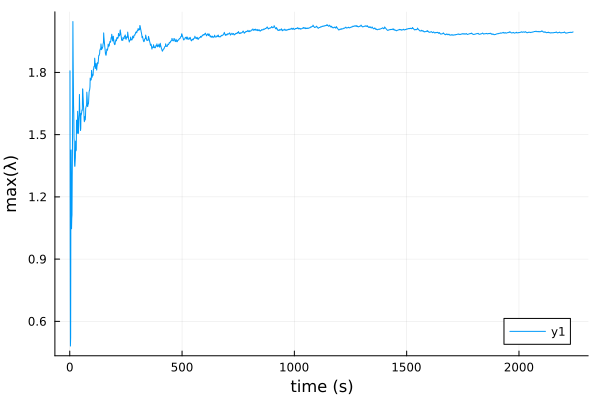

In [17]:
(times,lambdas)=iterate_lyapunov(lorenz_linear_tangent(σ,ρ,β),deltau, u,70000,90);
plot( lambdas ./ times, xlabel = "time (s)", ylabel = "max(λ)")

In [18]:
print(last(lambdas)/last(times))

1.9950050654839755

We now wrap up these operations in a function to see the evolution of the largest Lyapunov exponent with
ρ

In [19]:
function largestlyap(ρ)
    u0=[0.;0.1;0.1]
    (dummyt,u) = ode45(lorenz_model(σ,ρ,β), u0, t);
    δu=[0;0;1.]
    (times,lambdas)=iterate_lyapunov(lorenz_linear_tangent(σ,ρ,β), δu, u,120000,90)
    last(lambdas)/last(times)
end

largestlyap (generic function with 1 method)

In [20]:
largestlyap(23)

-0.052571553134038725

In [21]:
rhos=collect(1:.4:40)
lambdas = map(largestlyap,rhos);

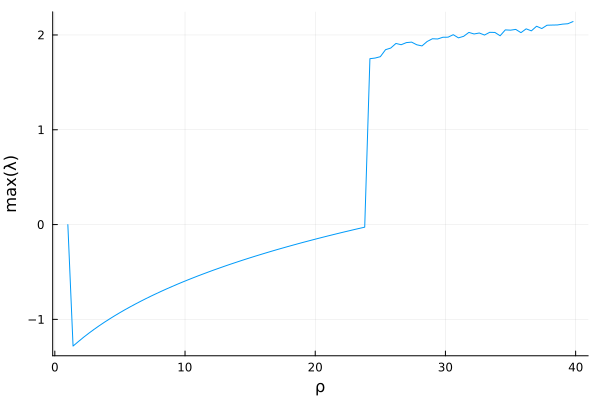

In [22]:
plot(rhos,lambdas, legend=false, xlabel ="ρ", ylabel ="max(λ)")

As we see it, the chaotic behaviour emerges for the $\rho_H$ value that we have predicted analytically.

In [23]:
rhos[first(findall(lambdas .> 0))]

24.2

--- 
# Phase Space simulations 
## Canonical phase space 

This code comes from : https://docs.juliaplots.org/latest/

[ Info: Saved animation to /home/amaury/Bureau/LINMA2361 - Systèmes dynamiques non linéaires/Projet/tmp.gif


Plots.AnimatedGif("/home/amaury/Bureau/LINMA2361 - Systèmes dynamiques non linéaires/Projet/tmp.gif")
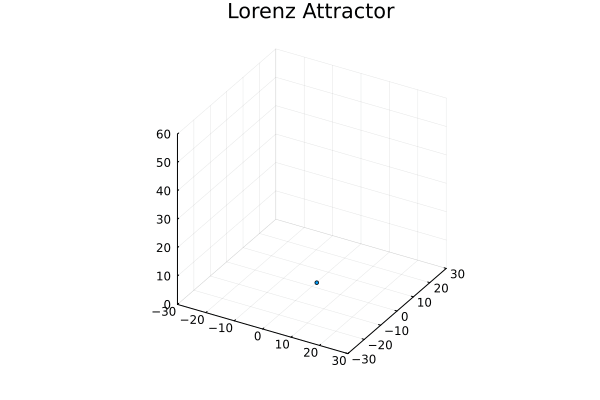

In [24]:
using Plots

# define the Lorenz attractor
Base.@kwdef mutable struct Lorenz
    dt::Float64 = 0.01
    σ::Float64 = 10
    ρ::Float64 = 28
    β::Float64 = 8/3
    x::Float64 = 1.
    y::Float64 = 1.
    z::Float64 = 1.
end


function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x)
    dy = l.x * (l.ρ - l.z) - l.y
    dz = l.x * l.y - l.β * l.z
    l.x += l.dt * dx
    l.y += l.dt * dy
    l.z += l.dt * dz
end

attractor = Lorenz()

# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    xlim = (-30, 30),
    ylim = (-30, 30),
    zlim = (0, 60),
    title = ("Lorenz Attractor"),
    legend = false,
    marker = 2,
)

# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:6500
    step!(attractor)
    push!(plt, attractor.x, attractor.y, attractor.z)
end every 10

## Lorenz model for $\rho \to \infty$

In [25]:
function lorenz_model()
    function lorenz(t,u)
        dxdt = u[2]
        dydt = -u[1]*u[3]
        dzdt = u[1]*u[2]
        [dxdt;dydt;dzdt]
    end
    return(lorenz)
end

lorenz_model (generic function with 2 methods)

In [26]:
dt = 0.001
tf = 100.0
t = collect(0:dt:tf)
u0=[1.5;1;1]
(t, u) = ode45(lorenz_model(), u0, t);

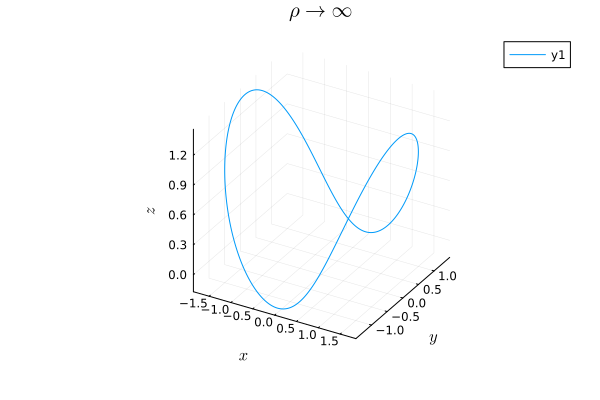

In [27]:
x = map(v -> v[1], u)
y = map(v -> v[2], u)
z = map(v -> v[3], u);

using Plots
using LaTeXStrings

plot(x,y,z, title = L" \rho \to \infty", xlabel = L"x", ylabel= L"y", zlabel = L"z")